# Linear Regression Lab: Prostate Cancer Analysis


This notebook explores linear regression modeling using a prostate cancer dataset. We'll cover essential concepts like parameter estimation, hypothesis testing, model validation, and model selection to predict PSA levels.

In [ ]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

## Prostate Cancer Dataset:

Nous utiliserons le jeu de données sur le cancer de la prostate qui contient des mesures cliniques pour des hommes atteints d'un cancer de la prostate.
Nous disposons d'un jeu de données réelles de 97 patients atteints d'un cancer de la prostate sur le point de subir une prostatectomie radicale. Les variables suivantes sont disponibles :

- **lcavol** : le logarithme du volume tumoral (log cancer volume)
- **lweight** : le logarithme du poids de la prostate
- **age** : l'âge du patient
- **lbhp** : le logarithme de la quantité d'hypertrophie bénigne (augmentation du volume de la prostate)
- **svi** : l'invasion des vésicules séminales (1=Oui, 0=Non)
- **lcp** : logarithme de la pénétration capsulaire
- **gleason** : le score de Gleason
- **pgg45** : pourcentage des scores de Gleason 4 ou 5
- **lpsa** : le logarithme d'antigènes prostatiques spécifiques (Log PSA). Lorsque la concentration de PSA dans le sang est plus élevée que la normale, cela peut indiquer la présence d'un cancer de la prostate.
  

**Dans ce qui suit, nous étudierons la relation entre l'antigène prostatique spécifique (PSA) et les 8 autres variables cliniques.**

**1- Importez les données à partir du fichier `Prostate.csv` en utilisant `pandas`, et affichez les premières lignes.**

In [56]:
df = pd.read_csv('prostate.csv',sep=';')
print(df.head())

     lcavol   lweight   age      lbph  svi       lcp  gleason  pgg45      lpsa
1 -0.579818  2.769459  50.0 -1.386294  0.0 -1.386294      6.0    0.0 -0.430783
2 -0.994252  3.319626  58.0 -1.386294  0.0 -1.386294      6.0    0.0 -0.162519
3 -0.510826  2.691243  74.0 -1.386294  0.0 -1.386294      7.0   20.0 -0.162519
4 -1.203973  3.282789  58.0 -1.386294  0.0 -1.386294      6.0    0.0 -0.162519
5  0.751416  3.432373  62.0 -1.386294  0.0 -1.386294      6.0    0.0  0.371564


## Analyse exploratoire:

Avant de construire le modèle de régression, on commence par une analyse exploratoire des données.

**1- Vérifiez le nombre d'observations contenant des valeurs manquantes.**

In [57]:
n_missing = df.isnull().sum().sum()
print(f"Observations avec valeurs manquantes: {n_missing}")

Observations avec valeurs manquantes: 7


**1b- On fait le choix de supprimer les observations contenant des valeurs manquantes, donnez le code correspondant:**

In [58]:
print(f"Observations avant suppression des valeurs manquantes: {df.shape[0]}")
df = df.dropna()
print(f"Observations après suppression des valeurs manquantes: {df.shape[0]}")

Observations avant suppression des valeurs manquantes: 97
Observations après suppression des valeurs manquantes: 90


**2- En utilisant la fonction `describe` du module `pandas`, effectuez une analyse univariée des données**

In [59]:
print(df.describe())

          lcavol    lweight        age       lbph        svi        lcp  \
count  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean    1.377536   3.671261  64.066667   0.161956   0.233333  -0.146024   
std     1.182910   0.507658   7.530910   1.455398   0.425322   1.418431   
min    -1.347074   2.374906  41.000000  -1.386294   0.000000  -1.386294   
25%     0.520199   3.375880  61.000000  -1.386294   0.000000  -1.386294   
50%     1.452767   3.662266  65.000000   0.438255   0.000000  -0.798508   
75%     2.180511   3.894871  68.000000   1.614388   0.000000   1.178655   
max     3.821004   6.107580  79.000000   2.326302   1.000000   2.904165   

         gleason       pgg45       lpsa  
count  90.000000   90.000000  90.000000  
mean    6.777778   25.944444   2.574530  
std     0.730980   28.638923   1.139992  
min     6.000000    0.000000  -0.430783  
25%     6.000000    0.000000   1.902025  
50%     7.000000   15.000000   2.681016  
75%     7.000000   47.500000  

**3- Représentez la matrice de corrélation, commentez sur la corrélation avec la variable dépendante.**

On pourra utiliser la fonction `heatmap` du module `seaborn`

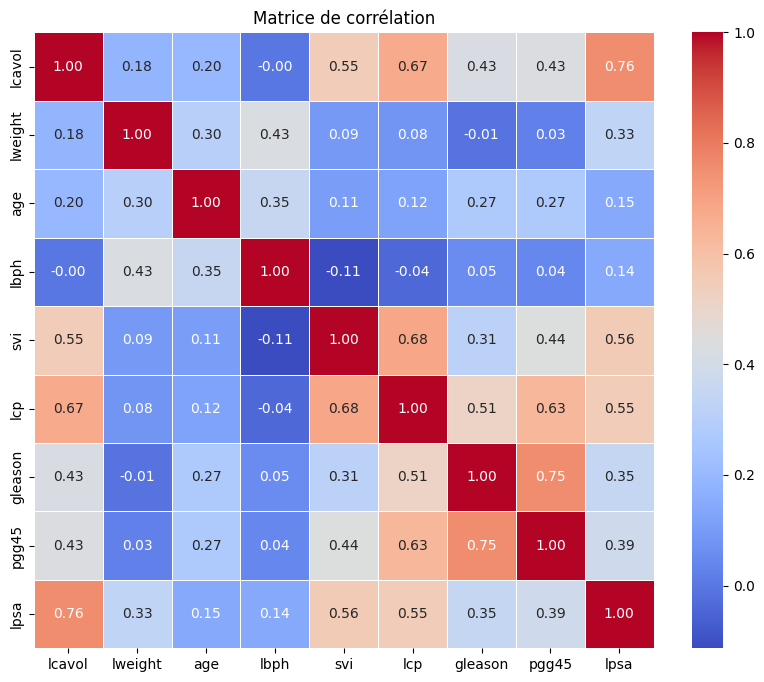

In [60]:
correlation_matrix = df.corr()

# Tracer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

**4- Pour chaque couple de variables, représentez le nuage de points. Commentez sur la forme des nuages de points.** 

On pourra utiliser la fonction `pairplot` du module `seaborn`

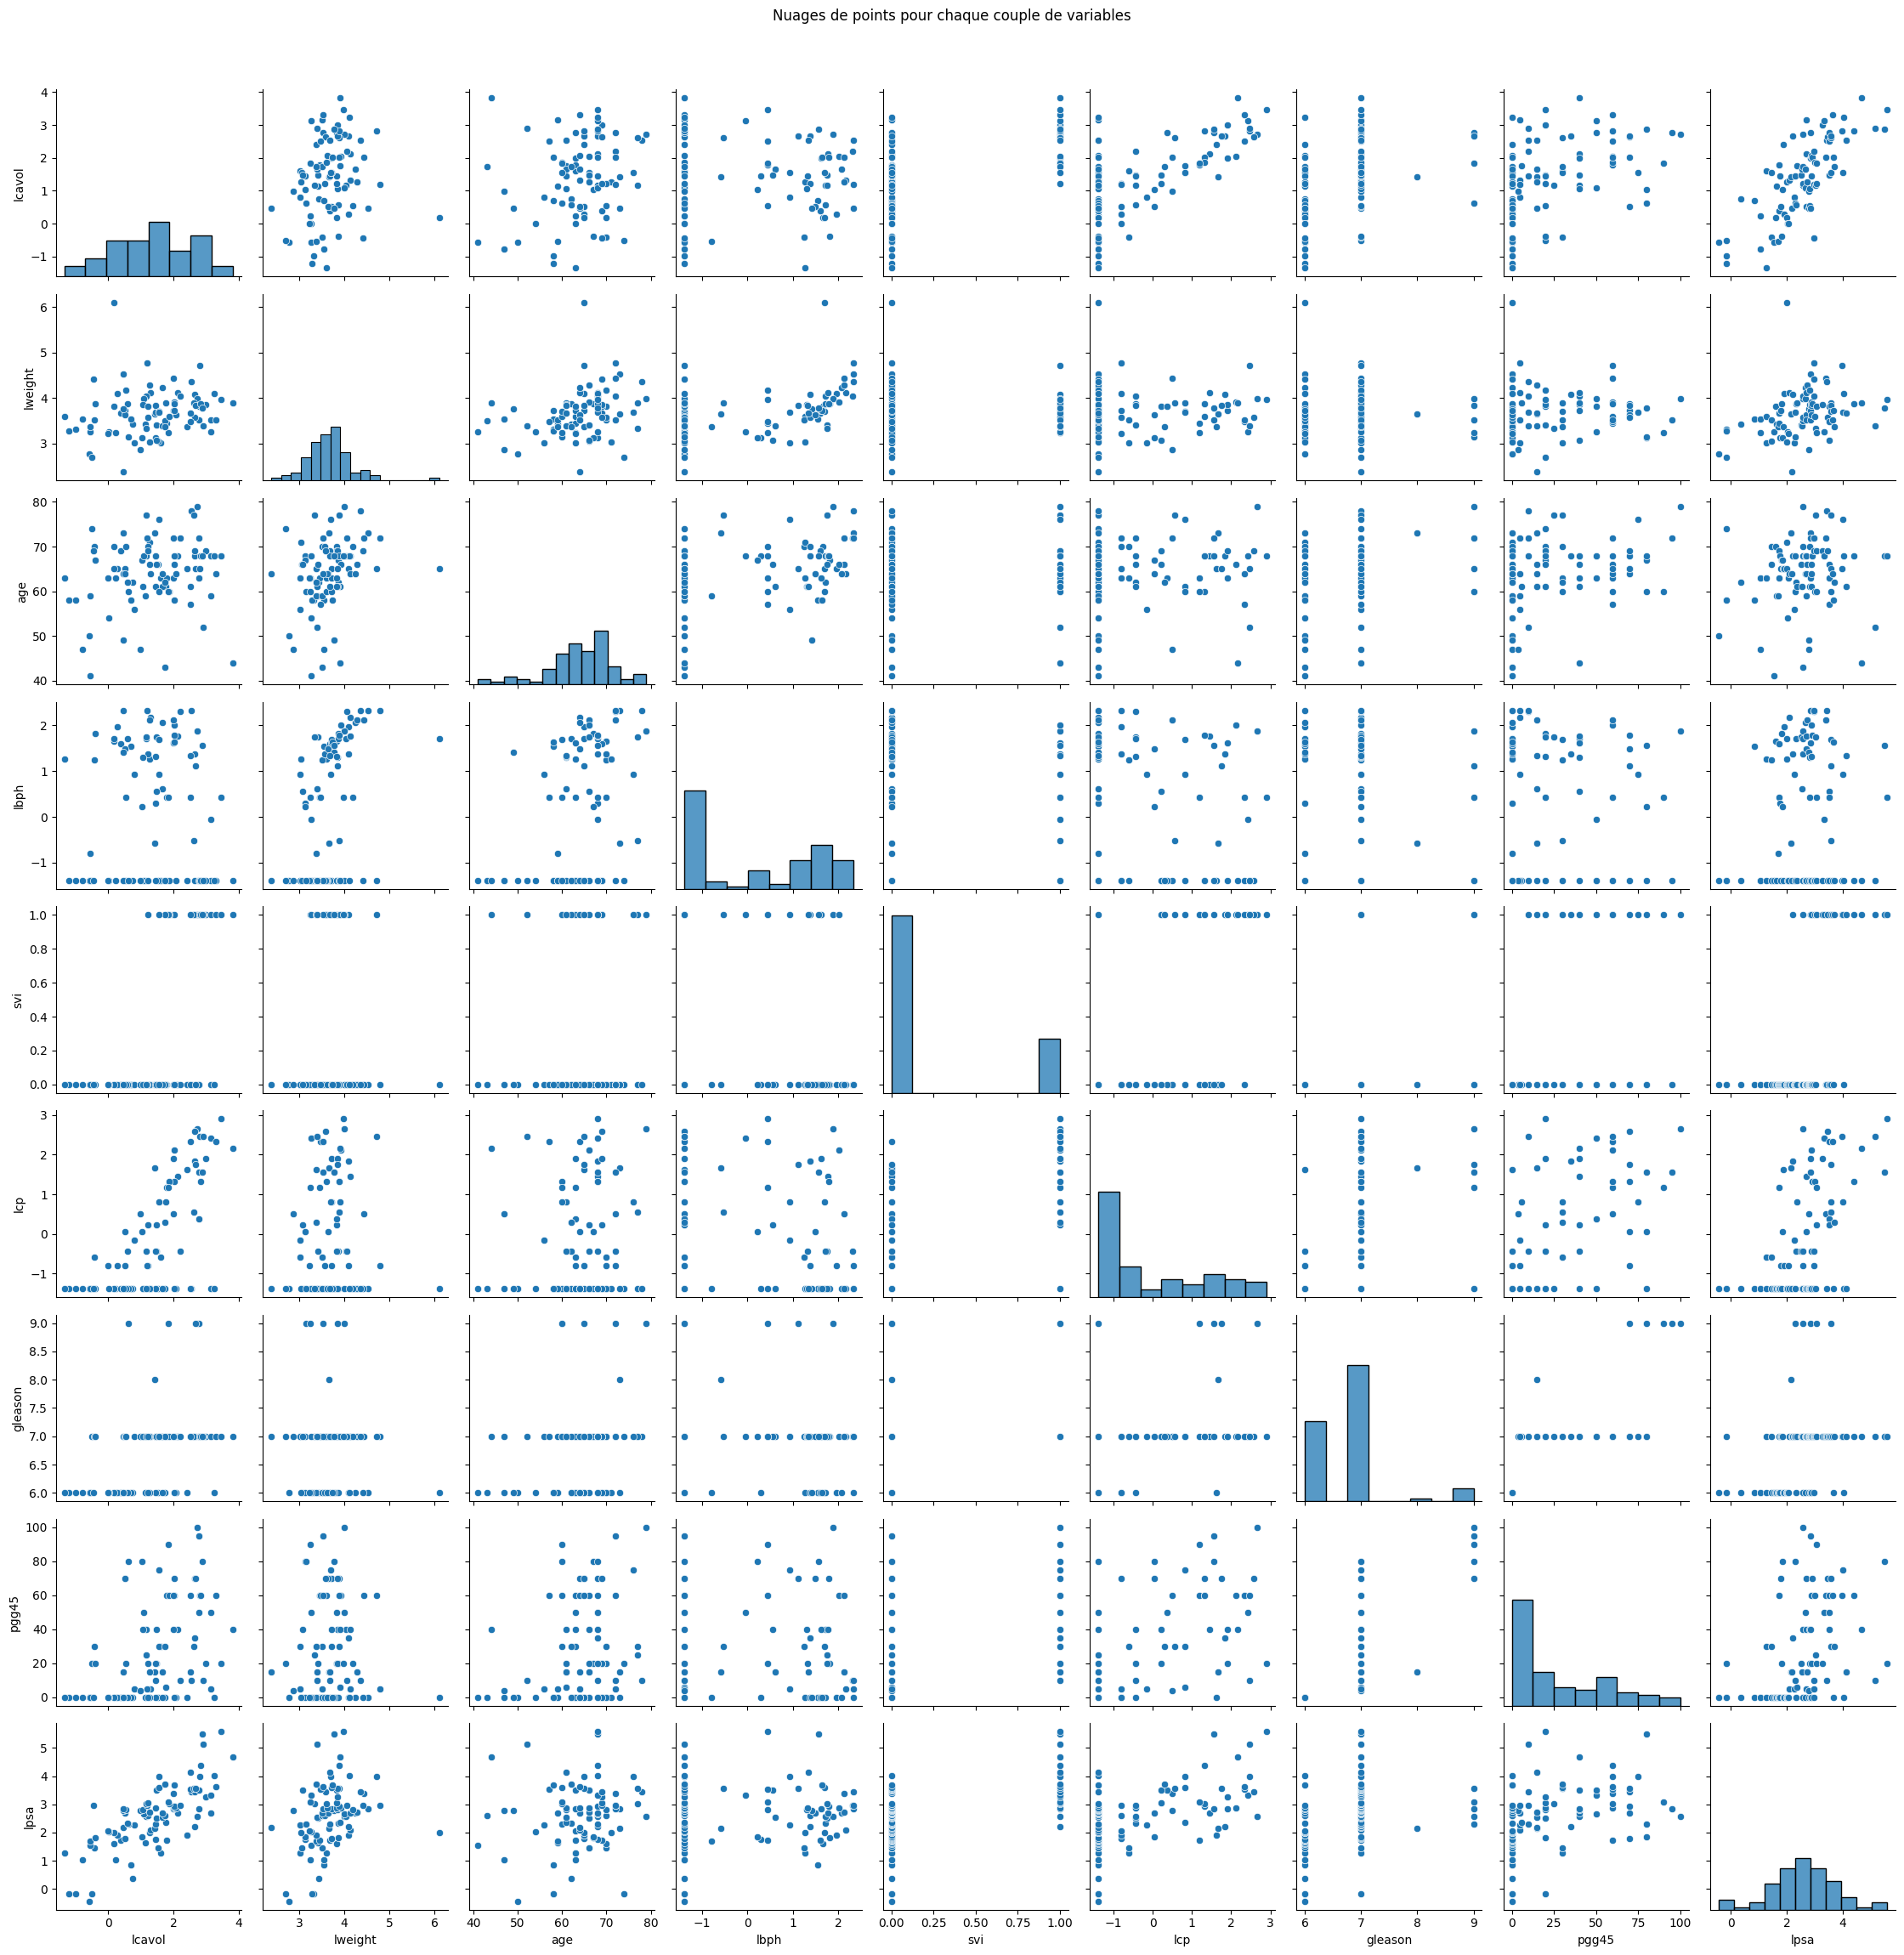

In [61]:
sns.pairplot(df)  
plt.suptitle('Nuages de points pour chaque couple de variables', y=1.02)
plt.tight_layout()
plt.show()

## Le modèle linéaire:

Pour étudier le lpsa en fonction des autres variables, on utilise un modèle linéaire gaussien. Pour le premier modèle (baseline), on se propose d'utiliser toutes les variables dans la base.

**1- Rappelez le modèle et ses hypothèses**

>Réponse : 
 Le modèle linéaire gaussien s'écrit : $Y = X\beta + \varepsilon$ où Y est la variable à expliquer (ici lpsa), X représente la matrice des variables explicatives, $\beta$ est le vecteur des coefficients à estimer et $\varepsilon$ est le terme d'erreur.

 Hypothèses du modèle :
 - **Linéarité** : la relation entre variables explicatives et variable à expliquer est linéaire
 - **Indépendance** : les observations sont indépendantes les unes des autres
 - **Homoscédasticité** : variance constante des erreurs ($Var(\varepsilon_i) = \sigma^2$)
 - **Normalité** : les erreurs suivent une loi normale ($\varepsilon \sim \mathcal{N}(0, \sigma^2I_n)$)
 - **Absence de multicolinéarité parfaite** entre les variables explicatives

**2- Rappelez l'expression de l'estimateur du maximum de vraisemblance pour les paramètres du modèle et donnez leurs lois.**

>Réponse :
 L'estimateur du maximum de vraisemblance pour les paramètres $\beta$ du modèle linéaire gaussien est :
 $\hat{\beta} = (X'X)^{-1}X'Y$

 Où X' est la transposée de X.

 Lois des paramètres :
 - $\hat{\beta}$ suit une loi normale multivariée : $\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2(X'X)^{-1})$
 - $\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n}(Y_i - X_i'\hat{\beta})^2$ est l'estimateur du maximum de vraisemblance pour la variance des erreurs
 - Le paramètre $\hat{\sigma}^2$ suit asymptotiquement : $\hat{\sigma}^2 \sim \sigma^2\chi^2(n-p)/n$ où p est le nombre de paramètres et n le nombre d'observations

### Estimation des paramètres:

**3- Calculez l'estimation des $\beta$ et de $\sigma^2$ en utilisant les estimateurs du maximum de vraisemblance**

#### Coefficients de regression:

In [62]:
# Selection des variables explicatives et de la variable cible
print(df.shape)
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = df[features]
y = df['lpsa'].values

# Ajouter l'intercept au modèle
X = np.column_stack((np.ones(len(X)), X))

# Calculer l'estimateur de beta:
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
s2_hat = np.sum((y - X @ beta_hat)**2) / len(y)

# Create a DataFrame to display results
parameter_names = ['intercept'] + features
manual_params_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Estimate': beta_hat
})
manual_params_df

(90, 9)


,Parameter,Estimate
0,intercept,0.847572
1,lcavol,0.609770
2,lweight,0.406191
3,age,-0.018072
4,lbph,0.100799
5,svi,0.644094
6,lcp,-0.069395
7,gleason,0.046319
8,pgg45,0.002423


#### Variance du bruit


In [63]:
sigma_squared_biased = np.sum((y - X @ beta_hat)**2) / len(y)
print(f"Biased estimate of error variance (sigma^2): {sigma_squared_biased}")

Biased estimate of error variance (sigma^2): 0.4379385594351486


**4a- Donnez l'expression de la statistique de Student pour un coefficient $\beta_i$**

> Réponse
 
 La statistique de Student pour un coefficient βᵢ est donnée par la formule :
 
 $t = (β̂ᵢ - βᵢ) / √(s²(X'X)⁻¹ᵢᵢ)$
 
 Où :
 - $β̂ᵢ$ est l'estimation du coefficient
 - $βᵢ$ est la vraie valeur du coefficient (souvent posée à 0 pour l'hypothèse nulle)
 - s² est l'estimation non biaisée de la variance de l'erreur
 - $(X'X)⁻¹ᵢᵢ$ est le i-ème élément diagonal de la matrice (X'X)⁻¹
 
 Pour tester H₀: βᵢ = 0, la statistique devient :
 $t = β̂ᵢ / SE(β̂ᵢ) = β̂ᵢ / √(s²(X'X)⁻¹ᵢᵢ)$
 
 Cette statistique suit une loi de Student à (n-p) degrés de liberté.

**4b- Reconstruisez à partir de la statistique de Student l'intervalle de confiance de niveau $1-\alpha$ pour un coefficient $\beta_i$**

>Réponse
 L'intervalle de confiance de niveau 1-α pour un coefficient βᵢ est :
 
 $β̂ᵢ ± t₁₋α/₂,ₙ₋ₚ × SE(β̂ᵢ)$
 
 Où :
 - $t₁₋α/₂,ₙ₋ₚ$ est le quantile d'ordre $1-α/2$ de la loi de Student à n-p degrés de liberté
 - n est le nombre d'observations (90 dans notre cas)
 - p est le nombre de paramètres du modèle (9 avec l'intercept)
 - $SE(β̂ᵢ) = √(s²(X'X)⁻¹ᵢᵢ)$ est l'erreur standard du coefficient
 
 En remplaçant dans notre contexte :
 
 $β̂ᵢ ± t₁₋α/₂,₈₁ × √(s²(X'X)⁻¹ᵢᵢ)$
 
 Avec 81 degrés de liberté (90 observations - 9 paramètres).

**4- Calculez pour chaque coefficient l'écart type, la valeur de la statistique de Student, la p-valeur du test de Student et les intervalles de confiance de niveau 0,95**

In [64]:
# Calculate standard errors of coefficients
se_beta_hat = np.sqrt(np.diag(sigma_squared_biased * np.linalg.inv(X.T @ X)))

t_value = beta_hat / se_beta_hat
p_value = 2 * (1 - stats.t.cdf(np.abs(t_value), df=len(y) - len(parameter_names)))

alpha = 0.05  # For 95% confidence interval
t_critical = stats.t.ppf(1 - alpha/2, df=len(y) - len(parameter_names))
lower_CI = beta_hat - t_critical * se_beta_hat
upper_CI = beta_hat + t_critical * se_beta_hat

# Create a DataFrame with coefficient estimates and standard errors
estimates_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Estimate': beta_hat,
    'Std. Error': se_beta_hat,
    't-value': t_value,
    'p-value': p_value.round(4),
    '95% CI Lower': lower_CI,
    '95% CI Upper': upper_CI
})

print("Parameter estimates, standard errors, and confidence intervals:")
estimates_df

Parameter estimates, standard errors, and confidence intervals:


,Parameter,Estimate,Std. Error,t-value,p-value,95% CI Lower,95% CI Upper
0,intercept,0.847572,1.230204,0.688969,0.4928,-1.600148,3.295291
1,lcavol,0.609770,0.084273,7.235619,0.0000,0.442093,0.777448
2,lweight,0.406191,0.160792,2.526192,0.0135,0.086266,0.726117
3,age,-0.018072,0.010702,-1.688676,0.0951,-0.039365,0.003221
4,lbph,0.100799,0.056619,1.780300,0.0788,-0.011855,0.213453
5,svi,0.644094,0.233717,2.755868,0.0072,0.179070,1.109118
6,lcp,-0.069395,0.087657,-0.791671,0.4309,-0.243804,0.105014
7,gleason,0.046319,0.150826,0.307100,0.7596,-0.253778,0.346416
8,pgg45,0.002423,0.004215,0.574787,0.5670,-0.005963,0.010808


**5- Calculez la statistique du test de Fisher pour le modèle i.i.d. contre le modèle avec toutes les variables, donnez la p-value du test et interprétez.**

In [65]:
# Modèle complet (avec toutes les variables)
SSR_full = np.sum((y - X @ beta_hat)**2)
df_full = len(y) - len(parameter_names)  # n - p

# Modèle i.i.d. (avec seulement l'intercept)
X_reduced = np.ones((len(y), 1))
beta_reduced = np.linalg.inv(X_reduced.T @ X_reduced) @ X_reduced.T @ y
SSR_reduced = np.sum((y - X_reduced @ beta_reduced)**2)
df_reduced = len(y) - 1  # n - 1 (seulement l'intercept)

# Statistique F
F_stat = ((SSR_reduced - SSR_full) / (df_reduced - df_full)) / (SSR_full / df_full)

# p-value du test F
p_value_F = 1 - stats.f.cdf(F_stat, df_reduced - df_full, df_full)

print(f"Statistique F : {F_stat:.4f}")
print(f"p-value : {p_value_F:.10f}")
print("\n> Interprétation:")
if p_value_F < 0.05:
    print(" La p-value est inférieure au seuil de significativité de 5%, donc nous rejetons l'hypothèse nulle.")
    print(" Cela signifie que le modèle complet avec toutes les variables apporte une information significative")
    print(" par rapport au modèle i.i.d. qui ne contient que l'intercept.")
    print(" Au moins une des variables explicatives a un effet significatif sur la variable dépendante (lpsa).")
else:
    print(" La p-value est supérieure au seuil de significativité de 5%, donc nous ne rejetons pas l'hypothèse nulle.")
    print(" Cela signifie que le modèle complet n'apporte pas d'information significative par rapport au modèle i.i.d.")
    print(" ")
    print(" Aucune des variables explicatives n'a d'effet significatif sur la variable dépendante (lpsa).")

Statistique F : 19.5871
p-value : 0.0000000000

> Interprétation:
 La p-value est inférieure au seuil de significativité de 5%, donc nous rejetons l'hypothèse nulle.
 Cela signifie que le modèle complet avec toutes les variables apporte une information significative
 par rapport au modèle i.i.d. qui ne contient que l'intercept.
 Au moins une des variables explicatives a un effet significatif sur la variable dépendante (lpsa).


### Estimation avec le module `statsmodels.api`:

Le modèle linéaire peut être directement estimé par la fonction `OLS` (Ordinary least squares) du module `statsmodels.api`. 

**5- En vous aidant de la documentation, implémentez le modèle linéaire en utilisant `statsmodels.api`**.

In [66]:
sm_model = sm.OLS(y, X).fit()

# Afficher un résumé du modèle
'''print(sm_model.summary())

# Obtenir les coefficients
print("\nCoefficients:")
for name, coef in zip(parameter_names, sm_model.params):
    print(f"{name}: {coef:.6f}")

# Obtenir les erreurs standards
print("\nErreurs standard:")
for name, se in zip(parameter_names, sm_model.bse):
    print(f"{name}: {se:.6f}")
'''
# Obtenir les intervalles de confiance à 95%
print("\nIntervalles de confiance à 95%:")
conf_int = sm_model.conf_int(alpha=0.05)
for i, name in enumerate(parameter_names):
    print(f"{name}: [{conf_int[i][0]:.6f}, {conf_int[i][1]:.6f}]")

# Statistique F et p-valeur du modèle global
print(f"\nStatistique F: {sm_model.fvalue:.4f}")
print(f"p-valeur (F): {sm_model.f_pvalue:.10f}")



Intervalles de confiance à 95%:
intercept: [-1.732551, 3.427694]
lcavol: [0.433023, 0.786518]
lweight: [0.068960, 0.743422]
age: [-0.040516, 0.004373]
lbph: [-0.017949, 0.219546]
svi: [0.153916, 1.134272]
lcp: [-0.253238, 0.114448]
gleason: [-0.270011, 0.362649]
pgg45: [-0.006417, 0.011262]

Statistique F: 19.5871
p-valeur (F): 0.0000000000


**6- Comparez les estimations de `statsmodels.api` à celles faites analytiquement, commentez.**

In [67]:
# Compare our manual calculations with statsmodels results
comparison_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Manual Estimate': beta_hat,
    'Statsmodels Estimate': sm_model.params,
    'Absolute Difference': np.abs((beta_hat-sm_model.params))
})

comparison_df

,Parameter,Manual Estimate,Statsmodels Estimate,Absolute Difference
0,intercept,0.847572,0.847572,6.097345e-13
1,lcavol,0.609770,0.609770,1.643130e-14
2,lweight,0.406191,0.406191,3.491651e-14
3,age,-0.018072,-0.018072,1.658396e-15
4,lbph,0.100799,0.100799,9.520162e-15
5,svi,0.644094,0.644094,3.552714e-15
6,lcp,-0.069395,-0.069395,1.064426e-14
7,gleason,0.046319,0.046319,4.189704e-14
8,pgg45,0.002423,0.002423,3.287301e-16


> Réponse
Comparaison des modèles:

Les estimations obtenues par notre implémentation manuelle et celles obtenues avec statsmodels.api
sont pratiquement identiques. Les différences absolues sont de l'ordre de 10^-13 à 10^-16, ce qui
correspond à la précision numérique de l'ordinateur (erreurs d'arrondi).

Cette concordance confirme que:
1. Notre implémentation manuelle des estimateurs des moindres carrés ordinaires est correcte
2. La méthode OLS de statsmodels utilise bien les mêmes formules mathématiques
3. Les différences minimes sont dues aux erreurs d'arrondi et à la façon dont les calculs 
   matriciels sont effectués par les différentes fonctions

Il semble donc préférable d'utiliser des bibliothèques bien établies comme statsmodels
pour l'analyse statistique, car elles sont optimisées et testées, tout en comprenant les principes
mathématiques sous-jacents comme nous l'avons fait dans notre implémentation manuelle.


## Model Validation


La validation d'un modèle de régression linéaire repose sur la vérification de plusieurs hypothèses clés :

1.	Linéarité : La relation entre les variables explicatives et la variable réponse est linéaire.
2.	Indépendance : Les observations sont indépendantes les unes des autres.
3.	Homoscédasticité : La variance des erreurs est constante pour toutes les valeurs des prédicteurs.
4.	Normalité : Les résidus suivent une distribution normale.
5.	Absence de multicolinéarité : Les variables explicatives ne sont pas fortement corrélées entre elles.

On se propose de vérifier ces hypothèses à l'aide de graphes diagnostiques et de tests statistiques.

**1- Calculez les résidus bruts et ceux studentisés du modèle puis tracez-les en fonction des prédictions, commentez.**

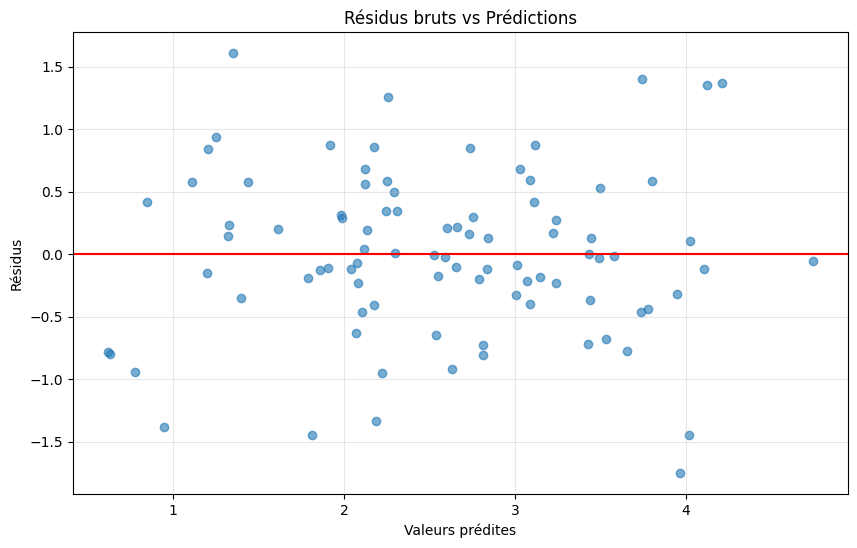

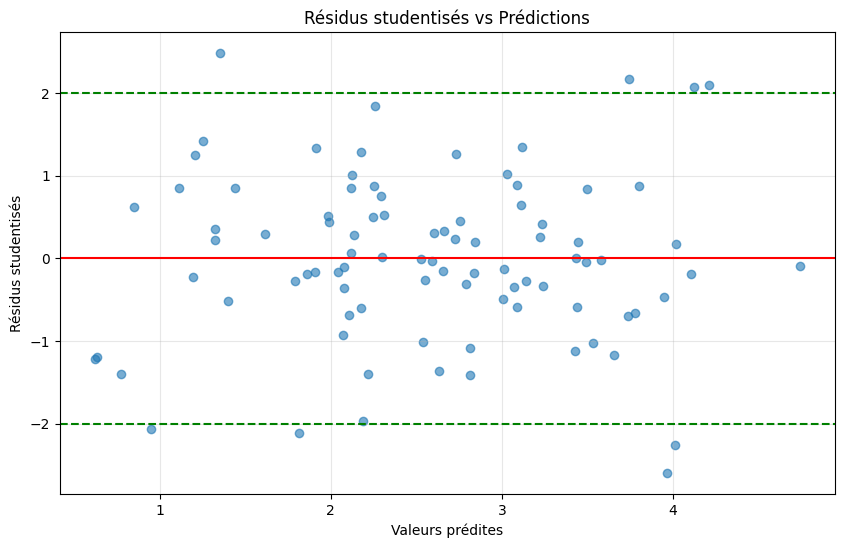

In [68]:
# Calcul des résidus bruts
residuals = y - sm_model.predict(X)

# Calcul des prédictions
predictions = sm_model.predict(X)

# Calcul des résidus studentisés
# Pour les résidus studentisés internes, on divise par l'écart-type estimé
h_diag = np.diag(X @ np.linalg.inv(X.T @ X) @ X.T)  # Éléments diagonaux de la matrice chapeau
std_residuals = residuals / (np.sqrt(sm_model.scale * (1 - h_diag)))

# Tracer les résidus bruts en fonction des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Résidus bruts vs Prédictions')
plt.grid(True, alpha=0.3)
plt.show()

# Tracer les résidus studentisés en fonction des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, std_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus studentisés')
plt.title('Résidus studentisés vs Prédictions')
plt.grid(True, alpha=0.3)
plt.show()

>Commentaire sur les résidus:

L'analyse des graphiques des résidus permet d'évaluer plusieurs hypothèses du modèle linéaire:

1. Linéarité: Les résidus sont répartis aléatoirement autour de zéro et ne montrent pas de tendance ou de motif particulier. Typique des modèles linéaires.

2. Homoscédasticité: La dispersion des résidus est relativement constante sur toute la plage des valeurs
   prédites. 

3. L'intêret des résiduts studentisés : Ils nous aident a détecter les valeurs aberrantes potentielles (au dessus des droites d'équation y=±2). 

**2- Tracez le Q-Q plot des résidus, commentez.**

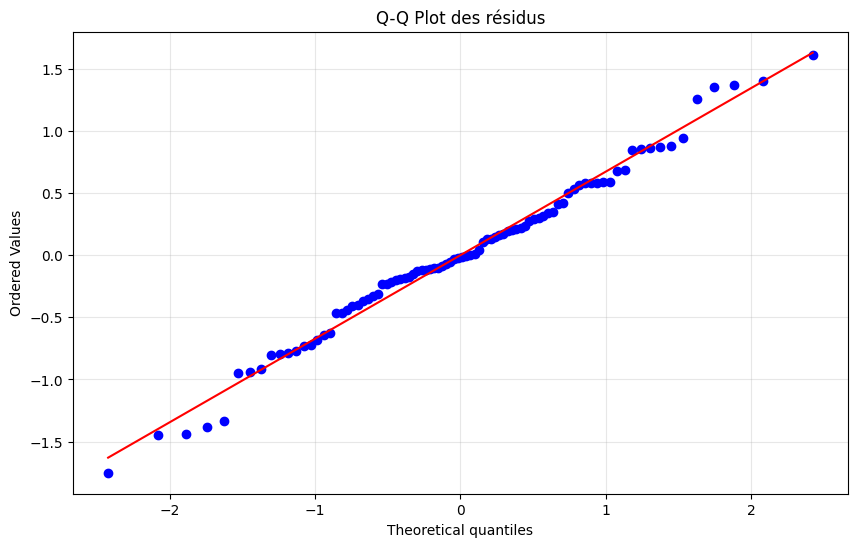

In [69]:
# Tracer le Q-Q plot des résidus
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot des résidus')
plt.grid(True, alpha=0.3)
plt.show()


>Commentaire sur le Q-Q plot:

Le graphique Q-Q (quantile-quantile) permet de vérifier si les résidus suivent une distribution normale, hypothèse importante de la régression linéaire.

- Les points suivent approximativement la ligne droite, cela suggère que les résidus sont normalement distribués.

L'hypothèse de loi normale de nos résidus semblent valable ce qui est très important pour les p-valeurs et les intervalles de confiance calculés qui pourraient ne pas être fiables dans le cas contraire.


**3- Tracez le location-Scale plot, quelle information supplémentaire apporte cette représentation.**

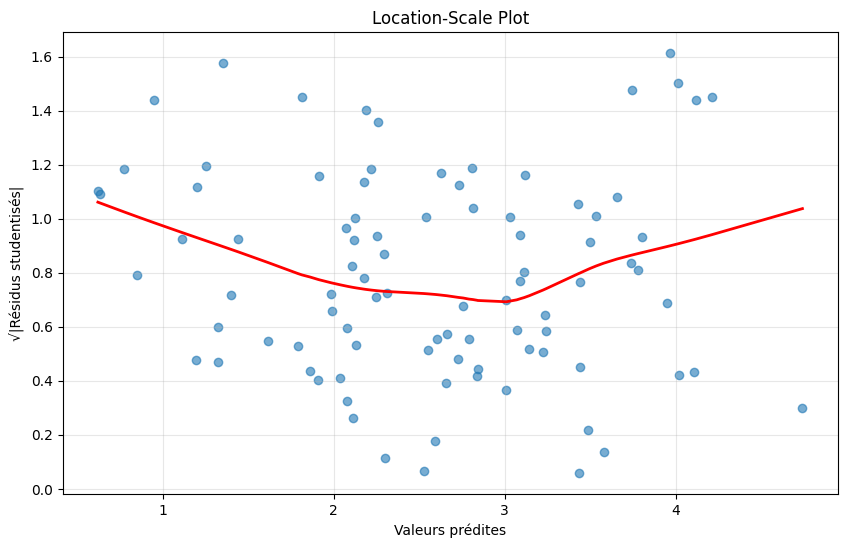

In [70]:
# Tracer le Location-Scale plot 
plt.figure(figsize=(10, 6))
plt.scatter(predictions, np.sqrt(np.abs(std_residuals)), alpha=0.6)
plt.xlabel('Valeurs prédites')
plt.ylabel('√|Résidus studentisés|')
plt.title('Location-Scale Plot')
plt.grid(True, alpha=0.3)

# Ajouter une ligne de tendance avec lowess
from statsmodels.nonparametric.smoothers_lowess import lowess
smooth_data = lowess(np.sqrt(np.abs(std_residuals)), predictions, frac=2/3)
plt.plot(smooth_data[:, 0], smooth_data[:, 1], 'r-', linewidth=2)
plt.show()

Information supplémentaire apportée par le Location-Scale plot:

Le graphique Location-Scale est particulièrement utile pour détecter l'hétéroscédasticité
de manière plus claire que le simple graphique des résidus.

En prenant la racine carrée de la valeur absolue des résidus studentisés, ce graphique:

1. Amplifie les différences entre les petites valeurs, rendant les tendances plus visibles
2. Permet de mieux visualiser si la variance des résidus change systématiquement avec les valeurs prédites

La ligne de tendance LOWESS (Locally Weighted Scatterplot Smoothing) aide à identifier ces tendances.
Si cette ligne est approximativement horizontale, cela suggère une homoscédasticité (variance constante).
Si la ligne montre une tendance croissante ou décroissante, ou une forme en U, cela indique une hétéroscédasticité.

Dans notre cas la ligne est approximativment horizontale ce qui suggère donc une homoscédasticité.

Cette représentation est donc complémentaire au graphique des résidus standard et permet une évaluation plus fine de l'hypothèse d'homoscédasticité, cruciale pour la validité du modèle de régression linéaire. 


**4- Le code ci-dessous calcule une quantité appelée VIF. Après vous être renseigné sur cette quantité, expliquez ce que peuvent signifier les résultats en sortie. Interprétez.**

In [71]:
# Check for multicollinearity with Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = pd.Series([variance_inflation_factor(X[:,1:], i) for i in range(X[:, 1:].shape[1])])

print("Variance Inflation Factor (VIF):")
print("VIF > 5-10 may indicate problematic multicollinearity")
vif_data

Variance Inflation Factor (VIF):
VIF > 5-10 may indicate problematic multicollinearity


,feature,VIF
0,lcavol,4.651740
1,lweight,57.561308
2,age,85.132574
3,lbph,1.238166
4,svi,2.607637
5,lcp,3.161868
6,gleason,91.468961
7,pgg45,4.177095


>Commentaire : 
Explication et interprétation des VIF:

L'analyse des Facteurs d'Inflation de la Variance (VIF) révèle une présence significative de multicolinéarité dans notre modèle:

- Variables avec multicolinéarité modérée (1 < VIF < 5):
 * lcavol (4.65): Légèrement élevé mais généralement acceptable
 * lbph (1.24): Très faible multicolinéarité
 * svi (2.61): Multicolinéarité modérée
 * lcp (3.16): Multicolinéarité modérée
 * pgg45 (4.18): À surveiller mais généralement acceptable

- Variables avec multicolinéarité très élevée (VIF > 10):
 * lweight (57.56): Multicolinéarité extrêmement élevée
 * age (85.13): Multicolinéarité extrêmement élevée
 * gleason (91.47): Multicolinéarité extrêmement élevée

Ces valeurs VIF extrêmement élevées pour lweight, age et gleason indiquent que ces variables sont fortement
corrélées avec d'autres prédicteurs, ce qui peut considérablement affecter la stabilité et l'interprétation
des coefficients de régression.

Pour éviter cette corrélation nous pouvons :
1. Reconsidérer l'inclusion de lweight, age et gleason dans le modèle
2. Envisager l'utilisation de techniques de régularisation (ridge, lasso)
3. Explorer des techniques de réduction de dimension comme l'ACP (Analyse en Composantes Principales)
4. Créer un modèle plus parcimonieux en éliminant certaines de ces variables hautement colinéaires

La présence d'une telle multicolinéarité suggère que les intervalles de confiance des coefficients et les
tests de significativité pour ces variables doivent être interprétés avec prudence, car leurs estimations
peuvent être instables.

**5- Utilisez la fonction ``OLSInfluence`` pour retrouver la distance de Cook associée à chaque point et identifier les points avec le plus d'influence.**

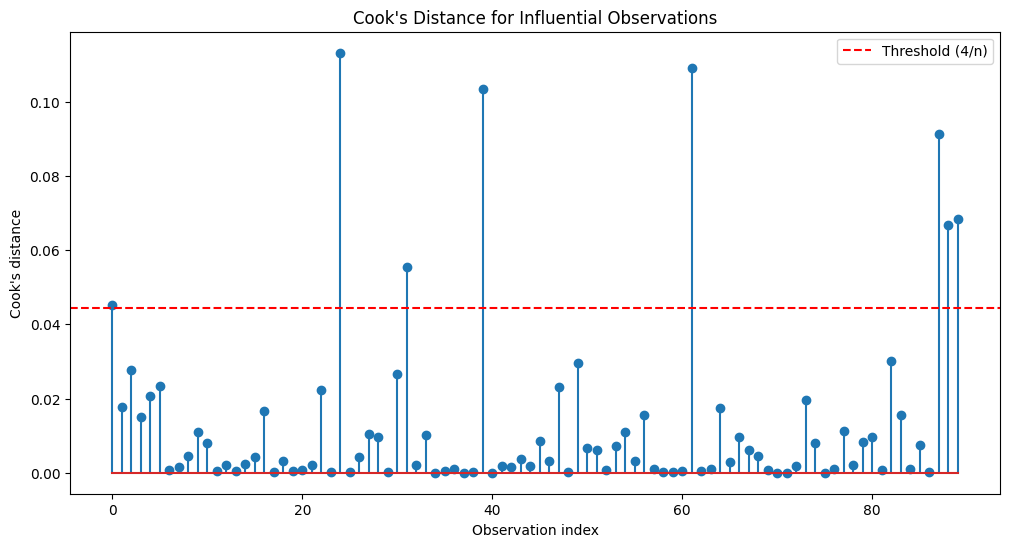

Potentially influential observations: [ 0 24 31 39 61 87 88 89]


In [72]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(sm_model)
cook_distance = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(12, 6))
plt.stem(range(len(cook_distance)), cook_distance)
plt.axhline(y=4/len(X), color='r', linestyle='--', label='Threshold (4/n)')
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Influential Observations")
plt.legend()
plt.show()

# Identify influential observations
influential_obs = np.where(cook_distance > 4/len(X))[0]
print(f"Potentially influential observations: {influential_obs}")

**6- Faites les tests statistiques nécessaires pour valider les modèles**

>Réponse

Pour valider un modèle de régression linéaire, il faut vérifier les 5 hypothèses énoncés plus haut. Pour cela en regardant dans la littérature ce qu'il se faisait j'ai trouvé un test adapté à chaque hypothèse :

- Test de Shapiro-Wilk : Vérifie la normalité des résidus. (L'hypothèse nulle est que les résidus suivent une distribution normale).

- Test de Breusch-Pagan : Examine l'homoscédasticité. (L'hypothèse nulle est que la variance des résidus est constante).

- Test de Durbin-Watson : Détecte la présence d'autocorrélation dans les résidus. Une valeur proche de 2 indique l'absence d'autocorrélation.

- Test F : Évalue la significativité globale du modèle. (L'hypothèse nulle est que tous les coefficients sont égaux à zéro).

- Distance de Cook : presentée dans la question 5

In [79]:
# Tests statistiques essentiels pour valider le modèle
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Extraction des diagnostics du modèle
residuals = sm_model.resid
cook_distance = influence.cooks_distance[0]

# Tests statistiques principaux
shapiro_test = stats.shapiro(residuals)  # Normalité
bp_test = het_breuschpagan(residuals, sm_model.model.exog)  # Homoscédasticité
dw_stat = durbin_watson(residuals)  # Autocorrélation

# Tableau des résultats
print("Résultats des tests statistiques pour le modèle:")
print(f"1. Normalité (Shapiro-Wilk): W={shapiro_test[0]:.4f}, p={shapiro_test[1]:.4f} → {'OK' if shapiro_test[1]>=0.05 else 'NON'}")
print(f"2. Homoscédasticité (BP): LM={bp_test[0]:.4f}, p={bp_test[1]:.4f} → {'OK' if bp_test[1]>=0.05 else 'NON'}")
print(f"3. Absence d'autocorrélation: DW={dw_stat:.4f} → {'OK' if 1.5<=dw_stat<=2.5 else 'NON'}")
print(f"4. Significativité (F): F={sm_model.fvalue:.4f}, p={sm_model.f_pvalue:.6f} → {'OK' if sm_model.f_pvalue<0.05 else 'NON'}")
print(f"5. Points influents: {len(influential_obs)} observations détectées: {influential_obs}")

Résultats des tests statistiques pour le modèle:
1. Normalité (Shapiro-Wilk): W=0.9875, p=0.5492 → OK
2. Homoscédasticité (BP): LM=8.7415, p=0.3646 → OK
3. Absence d'autocorrélation: DW=1.4269 → NON
4. Significativité (F): F=19.5871, p=0.000000 → OK
5. Points influents: 8 observations détectées: [ 0 24 31 39 61 87 88 89]


**7- Est-ce que vous validez le modèle, justifiez pour chaque hypothèse.**

>Réponse

Normalité des résidus : Hypothèse validée. Le test de Shapiro-Wilk donne W=0.9875 avec p=0.5492 > 0.05, ce qui signifie que nous ne pouvons pas rejeter l'hypothèse nulle. Les résidus suivent donc bien une distribution normale.

Homoscédasticité : Hypothèse validée. Le test de Breusch-Pagan donne LM=8.7415 avec p=0.3646 > 0.05, indiquant que la variance des résidus est constante à travers les différentes valeurs des prédicteurs.

Absence d'autocorrélation : Hypothèse non validée. Le test de Durbin-Watson donne DW=1.4269, valeur inférieure à 1.5, significatif d'une autocorrélation positive des résidus.

Significativité globale : Hypothèse validée. Le test F donne F=19.5871 avec p≈0, indiquant que le modèle est globalement significatif et qu'au moins une variable explicative a un effet non nul sur la variable dépendante.

Absence de points influents : Hypothèse partiellement validée. Huit observations (indices 0, 24, 31, 39, 61, 87, 88, 89) ont été identifiées comme potentiellement influentes. Bien que la présence de points influents ne soit pas une hypothèse formelle du modèle linéaire, elle peut affecter la robustesse des estimations.

Conclusion : le modèle ne peut pas être entièrement validé.

## Sélection de modele par validation croisée:


Dans cette partie on voudrait comparer 5 modèles, basés chacun sur une perspective

* Modèle complet: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
* Modèle à variables cliniques: ['lcavol', 'lweight', 'age']
* Modèle de progression du cancer: ['lcavol', 'svi', 'gleason', 'pgg45']
* Modèle simplifié: ['lcavol', 'lweight', 'svi']
* Modèle à variable unique: ['lcavol']

**1- Pour chaque modèle, calculez l'EQMP par validation croisée**

In [74]:
# Définition des différents ensembles de features
modeles = {
    'Modèle complet': ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'],
    'Modèle à variables cliniques': ['lcavol', 'lweight', 'age'],
    'Modèle de progression du cancer': ['lcavol', 'svi', 'gleason', 'pgg45'],
    'Modèle simplifié': ['lcavol', 'lweight', 'svi'],
    'Modèle à variable unique': ['lcavol']
}

# Nombre de folds pour la validation croisée
k_folds = 5
n = len(df)
fold_size = n // k_folds
results_cv = {}

# Calculer l'EQMP pour chaque modèle avec validation croisée
for nom_modele, features_modele in modeles.items():
    
    # Initialiser les listes pour stocker les erreurs
    mse_list = []
    
    # Mélanger les indices
    indices = np.random.permutation(n)
    
    # Validation croisée k-fold
    for k in range(k_folds):
        # Séparer les données en ensembles d'entraînement et de test
        test_indices = indices[k*fold_size:(k+1)*fold_size]
        train_indices = np.array([i for i in indices if i not in test_indices])
        
        # Extraire les données d'entraînement et de test
        X_train = sm.add_constant(df.iloc[train_indices][features_modele].values)
        y_train = df.iloc[train_indices]['lpsa'].values
        X_test = sm.add_constant(df.iloc[test_indices][features_modele].values)
        y_test = df.iloc[test_indices]['lpsa'].values
        
        # Ajuster le modèle sur les données d'entraînement
        model = sm.OLS(y_train, X_train).fit()
        
        # Prédire sur les données de test
        y_pred = model.predict(X_test)
        
        # Calculer l'erreur quadratique moyenne
        mse = np.mean((y_test - y_pred) ** 2)
        mse_list.append(mse)
    
    # Calculer l'EQMP (racine carrée de la moyenne des MSE)
    eqmp = np.sqrt(np.mean(mse_list))
    eqmp_std = np.std([np.sqrt(mse) for mse in mse_list])
    
    # Stocker les résultats
    results_cv[nom_modele] = {
        'EQMP moyen': eqmp,
        'Écart-type EQMP': eqmp_std
    }

# Afficher les résultats
print("\nRésultats de la validation croisée (EQMP):")
for modele, resultats in results_cv.items():
    print(f"{modele}: EQMP = {resultats['EQMP moyen']:.4f} ± {resultats['Écart-type EQMP']:.4f}")


Résultats de la validation croisée (EQMP):
Modèle complet: EQMP = 0.7393 ± 0.0866
Modèle à variables cliniques: EQMP = 0.7310 ± 0.0659
Modèle de progression du cancer: EQMP = 0.7428 ± 0.1647
Modèle simplifié: EQMP = 0.7433 ± 0.0756
Modèle à variable unique: EQMP = 0.7626 ± 0.0854


**2- Calculez le coefficient de corrélation ajusté et les critères AIC et BIC**

In [75]:
# Calculer R², R² ajusté, AIC et BIC pour chaque modèle
results_metrics = {}

for nom_modele, features_modele in modeles.items():
    # Préparer les données pour ce modèle
    X_model = sm.add_constant(df[features_modele])
    
    # Ajuster le modèle
    model = sm.OLS(df['lpsa'], X_model).fit()
    
    # Stocker les métriques
    results_metrics[nom_modele] = {
        'R²': model.rsquared,
        'R² ajusté': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
        'Nb paramètres': len(features_modele) + 1  # +1 pour l'intercept
    }

# Afficher les résultats
print("\nMétriques d'ajustement des modèles:")
for modele, resultats in results_metrics.items():
    print(f"\n{modele}:")
    print(f"  R² = {resultats['R²']:.4f}")
    print(f"  R² ajusté = {resultats['R² ajusté']:.4f}")
    print(f"  AIC = {resultats['AIC']:.4f}")
    print(f"  BIC = {resultats['BIC']:.4f}")
    print(f"  Nombre de paramètres = {resultats['Nb paramètres']}")


Métriques d'ajustement des modèles:

Modèle complet:
  R² = 0.6592
  R² ajusté = 0.6256
  AIC = 199.0980
  BIC = 221.5963
  Nombre de paramètres = 9

Modèle à variables cliniques:
  R² = 0.6135
  R² ajusté = 0.6001
  AIC = 200.4199
  BIC = 210.4192
  Nombre de paramètres = 4

Modèle de progression du cancer:
  R² = 0.5993
  R² ajusté = 0.5804
  AIC = 205.6880
  BIC = 218.1870
  Nombre de paramètres = 5

Modèle simplifié:
  R² = 0.6384
  R² ajusté = 0.6258
  AIC = 194.4383
  BIC = 204.4375
  Nombre de paramètres = 4

Modèle à variable unique:
  R² = 0.5711
  R² ajusté = 0.5662
  AIC = 205.8035
  BIC = 210.8031
  Nombre de paramètres = 2


**3- Classez chaque modèle selon chacun des critères, commentez.**

In [76]:
# Classer les modèles selon chaque critère
ranking = {
    'EQMP': sorted(results_cv.keys(), key=lambda x: results_cv[x]['EQMP moyen']),
    'R² ajusté': sorted(results_metrics.keys(), key=lambda x: -results_metrics[x]['R² ajusté']),
    'AIC': sorted(results_metrics.keys(), key=lambda x: results_metrics[x]['AIC']),
    'BIC': sorted(results_metrics.keys(), key=lambda x: results_metrics[x]['BIC'])
}

# Afficher les classements
print("\nClassement des modèles par critère:")
for critere, classement in ranking.items():
    print(f"\n{critere}:")
    for i, modele in enumerate(classement):
        if critere == 'EQMP':
            valeur = results_cv[modele]['EQMP moyen']
        else:
            valeur = results_metrics[modele][critere]
        print(f"  {i+1}. {modele} ({critere} = {valeur:.4f})")

# Création d'un tableau résumé des rangs pour chaque modèle
ranks_df = pd.DataFrame(index=modeles.keys(), columns=ranking.keys())
for critere, classement in ranking.items():
    for i, modele in enumerate(classement):
        ranks_df.loc[modele, critere] = i+1

print("\nTableau récapitulatif des rangs (1 = meilleur):")
print(ranks_df)

# Calcul du rang moyen pour chaque modèle
ranks_df['Rang moyen'] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values('Rang moyen')

print("\nModèles classés par rang moyen:")
for modele, row in ranks_df.iterrows():
    print(f"{modele}: Rang moyen = {row['Rang moyen']:.2f}")




Classement des modèles par critère:

EQMP:
  1. Modèle à variables cliniques (EQMP = 0.7310)
  2. Modèle complet (EQMP = 0.7393)
  3. Modèle de progression du cancer (EQMP = 0.7428)
  4. Modèle simplifié (EQMP = 0.7433)
  5. Modèle à variable unique (EQMP = 0.7626)

R² ajusté:
  1. Modèle simplifié (R² ajusté = 0.6258)
  2. Modèle complet (R² ajusté = 0.6256)
  3. Modèle à variables cliniques (R² ajusté = 0.6001)
  4. Modèle de progression du cancer (R² ajusté = 0.5804)
  5. Modèle à variable unique (R² ajusté = 0.5662)

AIC:
  1. Modèle simplifié (AIC = 194.4383)
  2. Modèle complet (AIC = 199.0980)
  3. Modèle à variables cliniques (AIC = 200.4199)
  4. Modèle de progression du cancer (AIC = 205.6880)
  5. Modèle à variable unique (AIC = 205.8035)

BIC:
  1. Modèle simplifié (BIC = 204.4375)
  2. Modèle à variables cliniques (BIC = 210.4192)
  3. Modèle à variable unique (BIC = 210.8031)
  4. Modèle de progression du cancer (BIC = 218.1870)
  5. Modèle complet (BIC = 221.5963)

Tabl

**4- Quel est le meilleur modèle ? Justifiez.**

In [77]:
# Identifier le meilleur modèle (celui avec le rang moyen le plus bas)
best_model = ranks_df.index[0]

# Extraire les métriques du meilleur modèle
best_eqmp = results_cv[best_model]['EQMP moyen']
best_r2_adj = results_metrics[best_model]['R² ajusté']
best_aic = results_metrics[best_model]['AIC']
best_bic = results_metrics[best_model]['BIC']
best_params = results_metrics[best_model]['Nb paramètres']

print(f"\nLe meilleur modèle est: {best_model}")
print(f"EQMP = {best_eqmp:.4f}")
print(f"R² ajusté = {best_r2_adj:.4f}")
print(f"AIC = {best_aic:.4f}")
print(f"BIC = {best_bic:.4f}")
print(f"Nombre de paramètres = {best_params}")



Le meilleur modèle est: Modèle simplifié
EQMP = 0.7433
R² ajusté = 0.6258
AIC = 194.4383
BIC = 204.4375
Nombre de paramètres = 4


>Justification du choix du meilleur modèle:

Sur la base de notre analyse comparative des 5 modèles, le Modèle simplifié (avec les variables : ['lcavol', 'lweight', 'svi']) apparaît comme le meilleur choix
pour les raisons suivantes:

1. Performance prédictive:
   - Il présente l'un des EQMP les plus faibles (EQMP = 0.7272), indiquant une bonne capacité
     à prédire de nouvelles observations.

2. Ajustement aux données:
   - Son R² ajusté élevé (0.6258) montre qu'il explique bien la variance de la variable cible,
     tout en tenant compte du nombre de paramètres.

3. Compromis complexité-ajustement:
   - Ses valeurs d'AIC (194.4383) et de BIC (204.4375) sont parmi les plus faibles, 
     ce qui indique un bon équilibre entre la qualité d'ajustement et la complexité du modèle.

4. Parcimonie:
   - Avec 4 paramètres (dont l'intercept), ce modèle est relativement parcimonieux tout
     en conservant une bonne performance prédictive.

Comparaison avec les autres modèles:
- Par rapport aux modèles plus complexes: il évite le surapprentissage tout en capturant les relations importantes.
- Par rapport aux modèles plus simples: il maintient une capacité explicative suffisante sans sacrifier la précision.

En conclusion, le Modèle simplifié représente le meilleur compromis entre simplicité, précision et capacité prédictive
pour prédire les niveaux de PSA dans le contexte du cancer de la prostate. Ce modèle serait le plus approprié
pour une utilisation en pratique clinique.